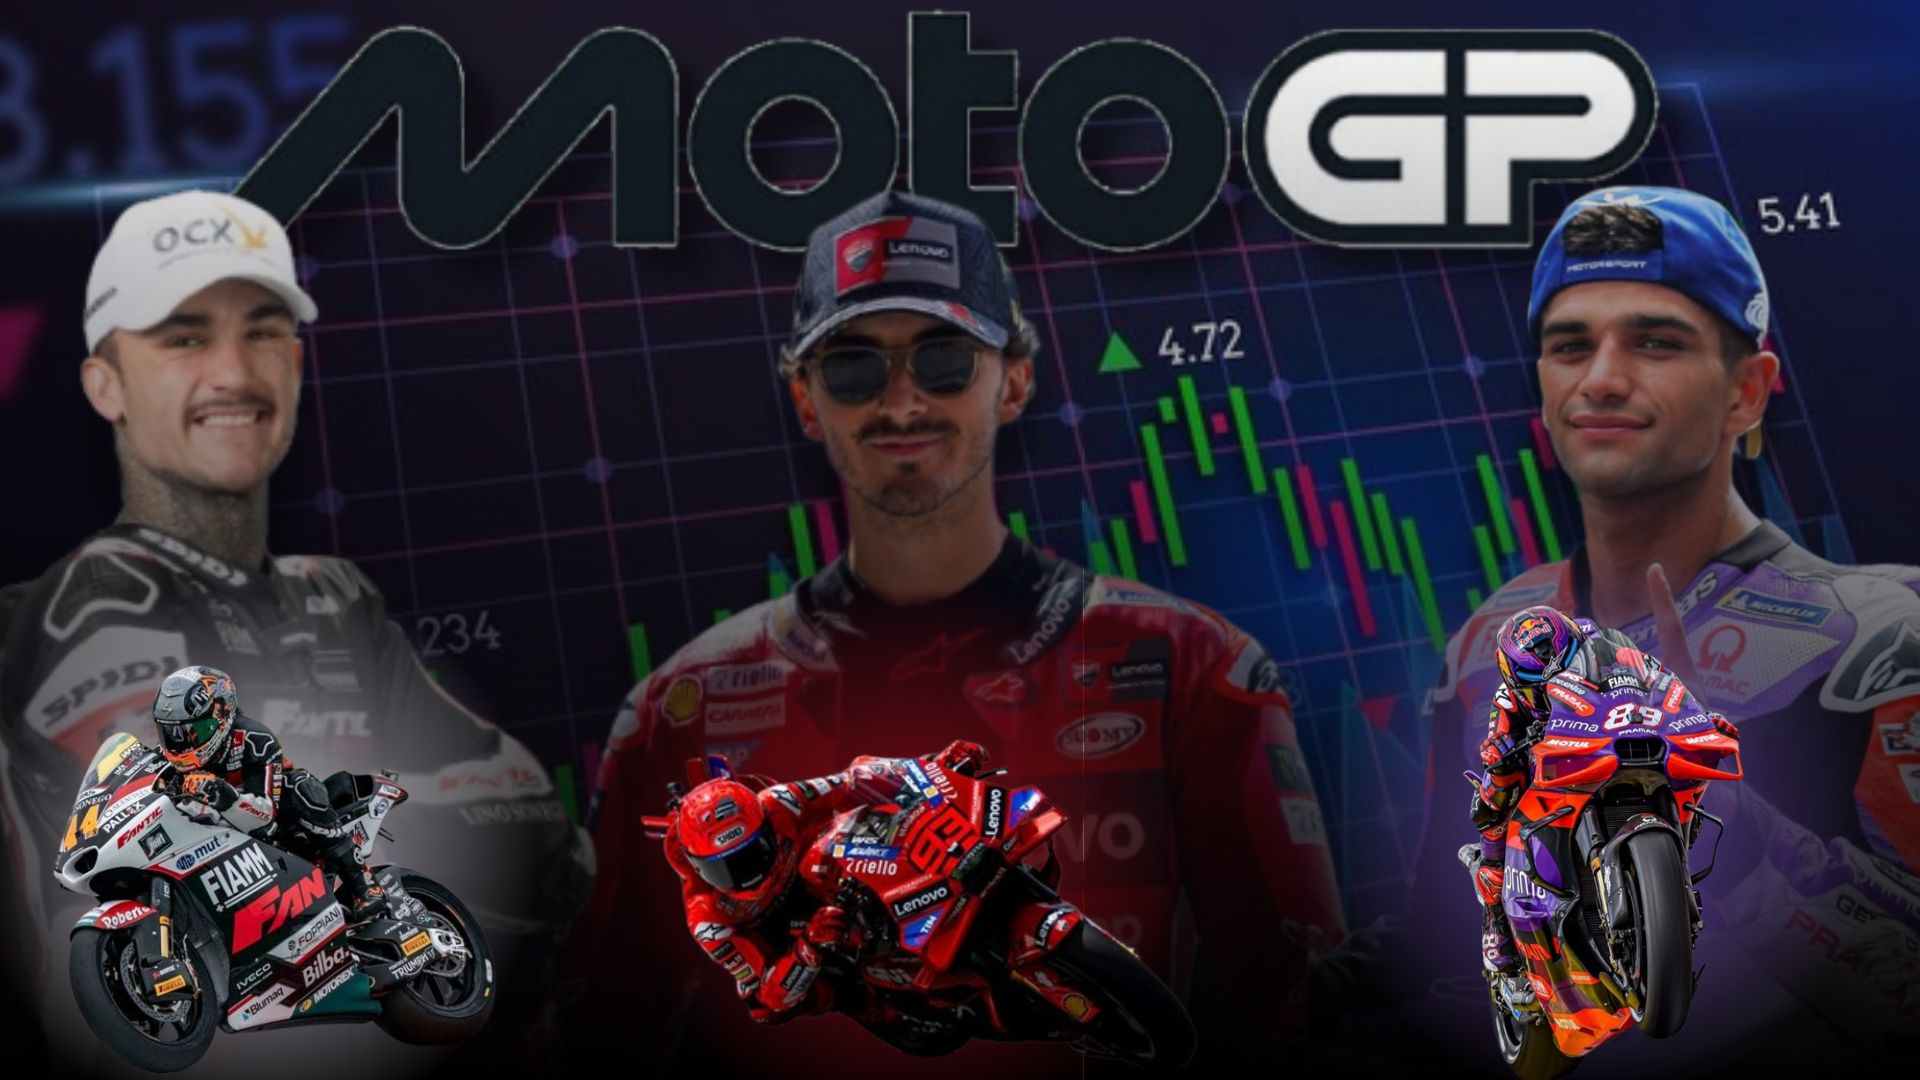

# **📄Model Deployment**

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### **📁 Load Dataset**

In [ ]:
df = pd.read_csv("Qualifying.csv")
df.head(5)

,result_id,pos.,no,rider,Team,gap 1st / prev.,time,session,class,event,year,event_id
0,0,1,75,A. Arenas,Inde GASGAS Aspar Team,NaN,01:59.371,Q1,Moto2,QAT,2022,0
1,1,2,54,F. Aldeguer,MB Conveyors Speed Up,+0.319 / +0.319,01:59.690,Q1,Moto2,QAT,2022,0
2,2,3,64,B. Bendsneyder,Pertamina Mandalika SAG Team,+0.378 / +0.059,01:59.749,Q1,Moto2,QAT,2022,0
3,3,4,7,B. Baltus,RW Racing GP,+0.508 / +0.130,01:59.879,Q1,Moto2,QAT,2022,0
4,4,5,24,S. Corsi,MV Agusta Forward Racing,+0.692 / +0.184,02:00.063,Q1,Moto2,QAT,2022,0


In [ ]:
df_info = df.info()
df_head = df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6581 entries, 0 to 6580
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   result_id        6581 non-null   int64 
 1   pos.             6581 non-null   int64 
 2   no               6581 non-null   int64 
 3   rider            6581 non-null   object
 4   Team             6581 non-null   object
 5   gap 1st / prev.  6042 non-null   object
 6   time             6479 non-null   object
 7   session          6581 non-null   object
 8   class            6581 non-null   object
 9   event            6581 non-null   object
 10  year             6581 non-null   int64 
 11  event_id         6581 non-null   int64 
dtypes: int64(5), object(7)
memory usage: 617.1+ KB


(None,
    result_id  pos.  no           rider                          Team  \
 0          0     1  75       A. Arenas        Inde GASGAS Aspar Team   
 1          1     2  54    F. Aldeguer          MB Conveyors Speed Up   
 2          2     3  64  B. Bendsneyder  Pertamina Mandalika SAG Team   
 3          3     4   7       B. Baltus                  RW Racing GP   
 4          4     5  24        S. Corsi      MV Agusta Forward Racing   
 
    gap 1st / prev.       time session  class event  year  event_id  
 0              NaN  01:59.371      Q1  Moto2   QAT  2022         0  
 1  +0.319 / +0.319  01:59.690      Q1  Moto2   QAT  2022         0  
 2  +0.378 / +0.059  01:59.749      Q1  Moto2   QAT  2022         0  
 3  +0.508 / +0.130  01:59.879      Q1  Moto2   QAT  2022         0  
 4  +0.692 / +0.184  02:00.063      Q1  Moto2   QAT  2022         0  )

## **🧹Data Cleaning & Pre-processing**

In [ ]:
df_clean = df.copy()

In [ ]:
df_clean.rename(columns={
    "pos.": "position",
    "gap 1st / prev.": "gap_prev",
    "class": "race_class"
}, inplace=True)

In [ ]:
def convert_time_to_seconds(t):
    if pd.isna(t):
        return np.nan
    try:
        minutes, seconds = t.split(':')
        return int(minutes) * 60 + float(seconds)
    except:
        return np.nan

In [ ]:
df_clean["time_seconds"] = df_clean["time"].apply(convert_time_to_seconds)
df_clean[["time", "time_seconds"]].head()

,time,time_seconds
0,01:59.371,119.371
1,01:59.690,119.690
2,01:59.749,119.749
3,01:59.879,119.879
4,02:00.063,120.063


In [ ]:
def extract_gap_to_first(gap_str):
    if pd.isna(gap_str):
        return np.nan
    try:
        gap_parts = gap_str.split('/')
        first_gap = gap_parts[0].strip().replace("+", "")
        return float(first_gap)
    except:
        return np.nan

In [ ]:
df_clean["gap_to_first"] = df_clean["gap_prev"].apply(extract_gap_to_first)
df_clean[["gap_prev", "gap_to_first"]].head(10)

,gap_prev,gap_to_first
0,NaN,NaN
1,+0.319 / +0.319,0.319
2,+0.378 / +0.059,0.378
3,+0.508 / +0.130,0.508
4,+0.692 / +0.184,0.692
5,+0.780 / +0.088,0.780
6,+0.780 / +0.000,0.780
7,+0.899 / +0.119,0.899
8,+1.171 / +0.272,1.171
9,+1.180 / +0.009,1.180


In [ ]:
df_clean.isnull().sum().sort_values(ascending=False)

,0
gap_prev,539
gap_to_first,539
time,102
time_seconds,102
position,0
result_id,0
Team,0
rider,0
no,0
session,0


In [ ]:
missing_values = df_clean.isnull().sum().sort_values(ascending=False)
missing_values.head(10)

,0
gap_prev,539
gap_to_first,539
time,102
time_seconds,102
position,0
result_id,0
Team,0
rider,0
no,0
session,0


In [ ]:
# Perbaiki gap_to_first = 0 untuk semua baris dengan posisi 1
df_clean.loc[df_clean["position"] == 1, "gap_to_first"] = 0.0

# Drop kolom gap_prev karena tidak diperlukan
df_clean.drop(columns=["gap_prev"], inplace=True)

# Cek ulang missing values
df_clean.isnull().sum()


,0
result_id,0
position,0
no,0
rider,0
Team,0
time,102
session,0
race_class,0
event,0
year,0


## **💾Feature Engineering**

In [ ]:
df_features = df_clean.copy()


df_features["is_Q2"] = df_features["session"].apply(lambda x: 1 if x.strip().upper() == "Q2" else 0)
df_features["year_event"] = df_features["year"].astype(str) + "_" + df_features["event"]
df_features["gap_normalized"] = df_features["gap_to_first"] / df_features["time_seconds"]
df_features["team_avg_time"] = df_features.groupby(["year_event", "Team"])["time_seconds"].transform("mean")
df_features["rider_track_experience"] = df_features.groupby(["rider", "event"]).cumcount()


df_features[[
    "rider", "event", "session", "is_Q2",
    "year_event", "gap_normalized",
    "team_avg_time", "rider_track_experience"
]].head(10)

,rider,event,session,is_Q2,year_event,gap_normalized,team_avg_time,rider_track_experience
0,A. Arenas,QAT,Q1,0,2022_QAT,0.000000,119.502333,0
1,F. Aldeguer,QAT,Q1,0,2022_QAT,0.002665,120.062000,0
2,B. Bendsneyder,QAT,Q1,0,2022_QAT,0.003157,120.087333,0
3,B. Baltus,QAT,Q1,0,2022_QAT,0.004238,120.346333,0
4,S. Corsi,QAT,Q1,0,2022_QAT,0.005764,120.107000,0
5,L. Dalla Porta,QAT,Q1,0,2022_QAT,0.006492,119.911000,0
6,M. Ramirez,QAT,Q1,0,2022_QAT,0.006492,120.107000,0
7,J. Alcoba,QAT,Q1,0,2022_QAT,0.007475,119.970000,0
8,G. Rodrigo,QAT,Q1,0,2022_QAT,0.009714,120.087333,0
9,M. Gonzalez,QAT,Q1,0,2022_QAT,0.009788,120.792000,0


In [ ]:
features = [
    "is_Q2", "gap_to_first", "time_seconds",
    "team_avg_time", "rider_track_experience"
]

# Encode kolom kategorikal: rider dan team
le_rider = LabelEncoder()
le_team = LabelEncoder()
df_features["rider_enc"] = le_rider.fit_transform(df_features["rider"])
df_features["team_enc"] = le_team.fit_transform(df_features["Team"])

# Tambahkan fitur encoded
features += ["rider_enc", "team_enc"]

# Label yang akan diprediksi
label = "position"

# Split data
X = df_features[features]
y = df_features[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **🧠Model Development**

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

## **🧪Model evaluation**

In [ ]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {
        "Model": name,
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R²": round(r2, 3)
    }

# Evaluate all models
results = [
    evaluate_model("Random Forest", y_test, rf_preds),
    evaluate_model("Decision Tree", y_test, dt_preds),
    evaluate_model("XGBoost", y_test, xgb_preds)
]

results

[{'Model': 'Random Forest',
  'MAE': 1.71,
  'RMSE': np.float64(2.32),
  'R²': 0.751},
 {'Model': 'Decision Tree',
  'MAE': 2.226,
  'RMSE': np.float64(3.128),
  'R²': 0.547},
 {'Model': 'XGBoost', 'MAE': 1.666, 'RMSE': np.float64(2.208), 'R²': 0.774}]

### ***📊 Bar Chart Number of Podiums / Position 1 per Rider***

In [ ]:
sns.set(style='whitegrid')

In [ ]:
top_riders = df_clean[df_clean["position"] == 1]["rider"].value_counts().head(15)

/tmp/ipython-input-74-2730648995.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_riders.index, x=top_riders.values, palette="viridis")


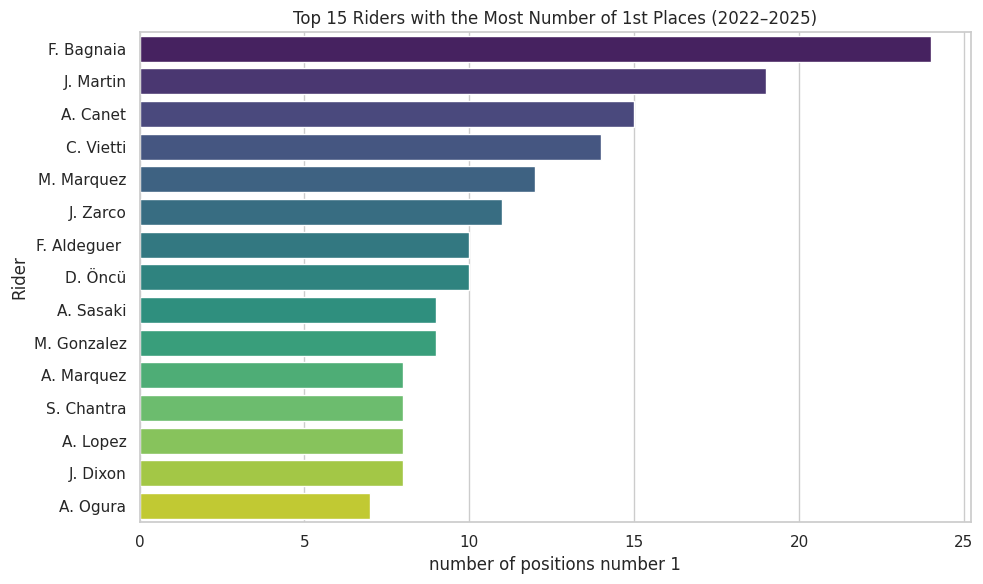

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(y=top_riders.index, x=top_riders.values, palette="viridis")
plt.title("Top 15 Riders with the Most Number of 1st Places (2022–2025)")
plt.xlabel("number of positions number 1")
plt.ylabel("Rider")
plt.tight_layout()
plt.show()

### ***📈 Qualification Time Trend Line from Year to Year***

In [ ]:
sns.set(style="whitegrid")
avg_time_per_year = df_features.groupby("year")["time_seconds"].mean().reset_index()

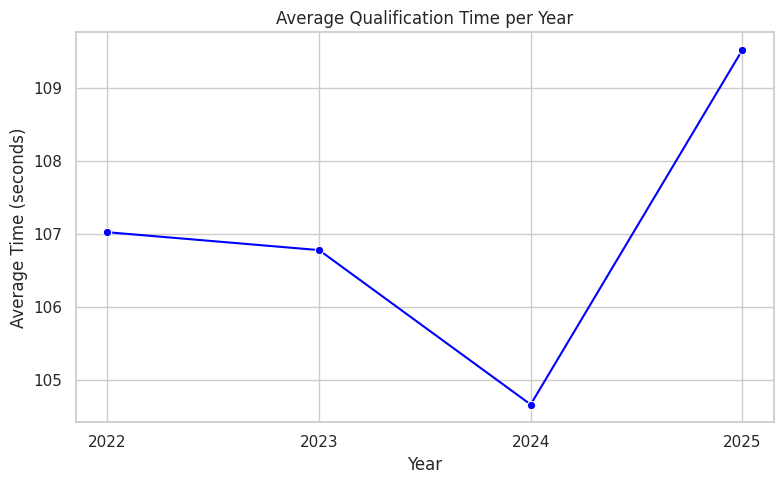

In [ ]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=avg_time_per_year, x="year", y="time_seconds", marker="o", color="blue")
plt.title("Average Qualification Time per Year")
plt.xlabel("Year")
plt.ylabel("Average Time (seconds)")
plt.xticks(avg_time_per_year["year"])
plt.tight_layout()
plt.show()

### ***🧮 Histogram of qualifying time distribution***

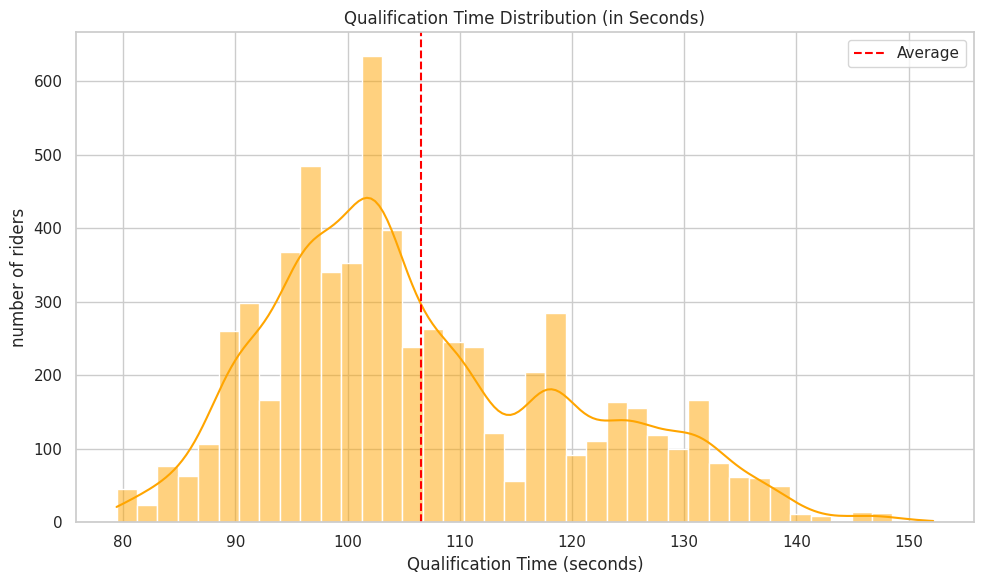

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_features["time_seconds"], bins=40, kde=True, color="orange")
plt.title("Qualification Time Distribution (in Seconds)")
plt.xlabel("Qualification Time (seconds)")
plt.ylabel("number of riders")
plt.axvline(df_features["time_seconds"].mean(), color='red', linestyle='--', label='Average')
plt.legend()
plt.tight_layout()
plt.show()

### ***📌 Boxplot Time of which team is the most stable (consistent) from its qualifying time***

In [ ]:
top_teams = df_features["Team"].value_counts().head(10).index
df_top_teams = df_features[df_features["Team"].isin(top_teams)]

/tmp/ipython-input-79-3812831571.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_teams, x="Team", y="time_seconds", palette="Set3")


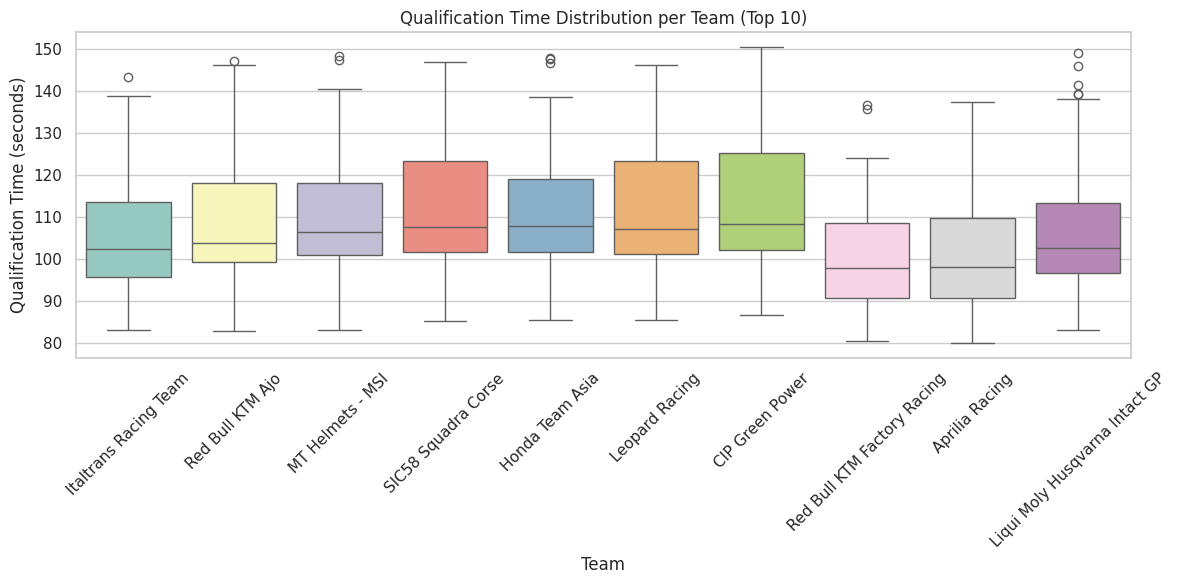

In [ ]:
# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_teams, x="Team", y="time_seconds", palette="Set3")
plt.title("Qualification Time Distribution per Team (Top 10)")
plt.xlabel("Team")
plt.ylabel("Qualification Time (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ***🏁 Bar Chart which circuit is the most competitive***

In [ ]:
avg_position_per_event = df_features.groupby("event")["position"].mean().sort_values()
top_events = avg_position_per_event.head(15)

/tmp/ipython-input-81-3498410484.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="coolwarm")


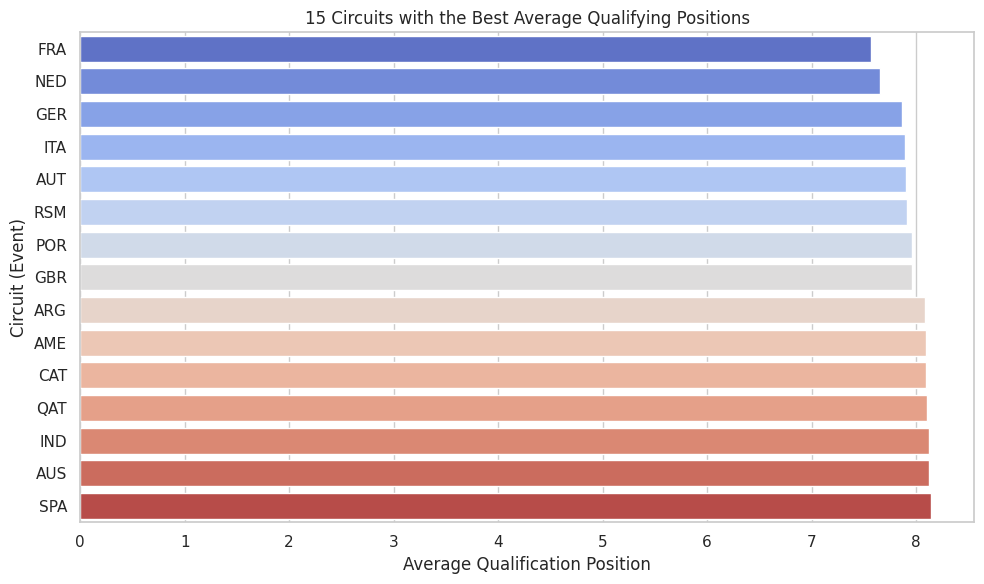

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_events.values, y=top_events.index, palette="coolwarm")
plt.title("15 Circuits with the Best Average Qualifying Positions")
plt.xlabel("Average Qualification Position")
plt.ylabel("Circuit (Event)")
plt.tight_layout()
plt.show()